# Abstract
This post examines threshold-choosing techniques that allow us to evaluate the efficacy of a classifier outside of the accuracy. Our case examines bank lending where our machine learning model must evaluate if a borrower is likely to default on their loans. In this scenario, it is much more costly for the bank to approve a loan that will be defaulted on than to reject a borrower that would have actually been able to pay back their loan. Because the errors are asymmetric in cost, we can find an optimal threshold for approving and denying loans, which will allow the bank to maximize profits. We use logistic regression on our dataset to find an optimal set of weights and then use the dot product to use these weights to convert our data to a probability that each prosepctive borrower will default. Based on these probabilities, we test a set of thresholds for allowable default risk and select the optimal one that will maximize profit. We find that the optimal threshold rejects any prospective borrower with a risk of default above $58\%$ and results in a profit of roughly $\$ 1400$ per prospective borrower. We also analyze how our threshold impacts different demographics of borrowers.

# Introduction
To loan or not to loan: That is the question which most often plagues the indecisive banker. For the siren call of unlimited riches in the form of monthly interest payments beckons, but can lead to certain doom for those who make hasty loans that end in default. So the banker is left with a choice: lay down anchor and decry all loans to avoid disaster or set sail into the perilous loan-giving waters in search of the glorious bounty that awaits. Fortunately for today's bankers, our modern day Prometheus--Big Tech--has bestowed upon us machines, which can make decisions autonomously, providing some solace for those who do not wish to bear the decision-making responsibility alone.

We can train one such machine learning model as follows, beginning by importing our trusty tools NumPy and Pandas as well as our training dataset. Our interest rates are given as percentages, which we will want to convert to a decimal for later calculations.

In [19]:
import pandas as pd
import numpy as np
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train['loan_int_rate'] = df_train["loan_int_rate"]/100 # Convert percentage to decimal
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,0.0991,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,0.1347,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,0.0751,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,0.1287,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,0.0963,0,0.28,N,10


We preprocess the data in a way that can be read by our machine by converting our categorical columns into dummy columns and dropping NA values. We also separate our target variable "loan_status", which is a $1$ if the borrower defaulted and a $0$ if the borrower paid back their loan. "loan_grade" is a measurement from the bank that determines the likelyhood that the loan is paid back. We want to remove this as well, as the goal is for our model to not be under the influence of outside evaluation methods.

In [20]:
def preprocess_data(df):
    df = df.dropna()
    y_train = df["loan_status"]
    df = df.drop(["loan_status", "loan_grade"], axis = 1)
    df = pd.get_dummies(df)
    return df, y_train

X_train, y_train = preprocess_data(df_train)
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,0.1347,0.12,6,False,False,False,True,False,True,False,False,False,False,False,True
2,22,36996,5.0,10000,0.0751,0.27,4,False,False,False,True,False,True,False,False,False,False,True,False
3,24,26000,2.0,1325,0.1287,0.05,4,False,False,False,True,False,False,False,True,False,False,True,False
4,29,53004,2.0,15000,0.0963,0.28,10,True,False,False,False,False,False,True,False,False,False,True,False
6,21,21700,2.0,5500,0.1491,0.25,2,False,False,False,True,False,False,True,False,False,False,True,False


# Exploring The Data

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

Our model is only as good as the data it is trained on, and as such, it is important for us to gain a strong understanding of our data before beginning the training process. The scatterplot on the left examines the relationship between two continuous features: "loan_percent_income" and "loan_int_rate", representing the percentage of the borrower's income that the requested loan consitutes and the the interest rate of the loan, respectively. Based on the scatterplot--which is colored by if the borrower defaulted--it appears that as both variables increase, the rate of default also increases. 

The barplot to the right examines the homeowner status of borrowers and the rate at which each of those groups default on their loans. Borrowers who were renters and had a status of "Other" had the highest rates of default at around $30\%$, while borrowers who had a mortgage or owned their homes had lower default rates of around $12\%$ and $9\%$, respectively.

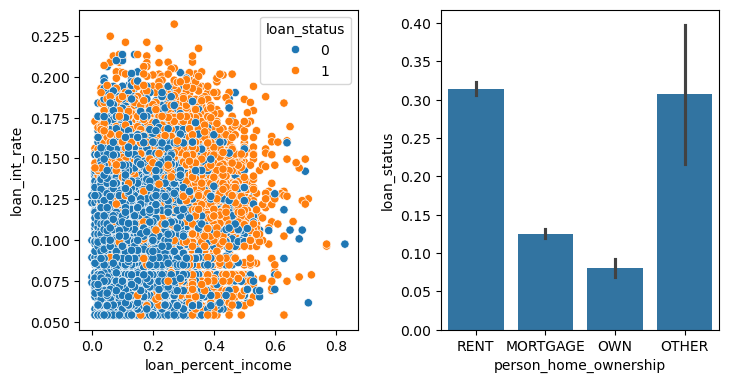

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
p1 = sns.scatterplot(df_train, x = "loan_percent_income", y = "loan_int_rate", hue = "loan_status", ax = ax[0])
p2 = sns.barplot(df_train, x = "person_home_ownership", y = "loan_status", ax = ax[1])

Using the table below, we can examine the outcomes for groups with varying intents for their loans. It appears that on average, the interest rate granted by the bank was around $11\%$, regardless of what the intent was for the loan. Venture loans had the lowest rate of default with a mean of $14.9\%$ while debt consolidation loans had the highest rate of default with a mean of $28.7\%$.

In [23]:
df_train.groupby(['loan_intent']).aggregate({'loan_int_rate': ['mean', 'std'],
                                             'loan_status': ['mean', 'std']})

loan_int_rate           loan_status          
                           mean       std        mean       std
loan_intent                                                    
DEBTCONSOLIDATION      0.109833  0.032782    0.287458  0.452631
EDUCATION              0.109655  0.031817    0.173396  0.378626
HOMEIMPROVEMENT        0.111601  0.033750    0.264645  0.441220
MEDICAL                0.110519  0.032451    0.263289  0.440463
PERSONAL               0.110098  0.032337    0.193739  0.395271
VENTURE                0.109409  0.032190    0.148678  0.355809

# Building The Model

This is where the fun begins: we can now build a model that will help us make loans that optimize our profits. We've chosen ol' reliable--Logistic Regression--as our model, which we can fit to a subset of the features in our data. "But which features?" you may be wondering. Great question! We can determine an ideal combination of features through a trial-and-error like process by fitting a model to different combinations of features and then performing cross-validation on each to determine which set will perform well on a new testing dataset. We define a function getCols() below to make sure all of our relevant categorical dummies are selected when choosing our features.

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def getCols(X, quant_cols, qual_cols):
  cols = quant_cols
  for qual in qual_cols: 
    expand_qual_cols = [col for col in X.columns if qual in col ]
    cols = np.concatenate((cols, expand_qual_cols))
  return cols

Our first combination of features uses both of the categorical variables we examined in our plots above as well as the interest rate, percentage of the borrowers income that the loan constitutes, the borrower's age, and the employment length of the borrower's most recent occupation. Based on our cross-validation test, these features score $84.4\%$. Nice!

In [25]:
qual_cols = ['person_home_ownership', 'loan_intent']
quant_cols = ['loan_int_rate', 'loan_percent_income', 'person_age', 'person_emp_length']
cols1 = getCols(X_train, quant_cols, qual_cols)
LR = LogisticRegression()
LR.fit(X_train[cols1], y_train)
cross_val_score(LR, X_train[cols1], y_train, cv = 5).mean()

c:\Users\omara\.conda\envs\ml451\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\omara\.conda\envs\ml451\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.8439336903961869

Our second combination ignores all categorical variables and just focuses on the interest rate and the loan's percentage of the borrower's income, which could be effective based on the trend we saw in the scatterplot above. We find a cross-validation score of $82.6\%$. While not as high as the previous combination, the cross-validation score is quite high, indicating a strong predictive power between these two features.

In [26]:
qual_cols = []
quant_cols = ['loan_int_rate', 'loan_percent_income']
cols2 = getCols(X_train, quant_cols, qual_cols)
LR = LogisticRegression()
LR.fit(X_train[cols2], y_train)
cross_val_score(LR, X_train[cols2], y_train, cv = 5).mean()

0.825773775136919

Our last combination uses the same features as the first combination but ignores the loan interest rate and the loan's percentage of the borrower's income. Using cross-validation, we get a score of $78.5\%$. 

In [27]:
qual_cols = ['person_home_ownership', 'loan_intent']
quant_cols = ['person_age', 'person_emp_length']
cols3 = getCols(X_train, quant_cols, qual_cols)
LR = LogisticRegression()
LR.fit(X_train[cols3], y_train)
cross_val_score(LR, X_train[cols3], y_train, cv = 5).mean()

c:\Users\omara\.conda\envs\ml451\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\omara\.conda\envs\ml451\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

0.7849565667540506

While accuracy is not the only consideration to be made when profitmaxxing (as we will get to in a moment), a higher accuracy and cross-validation score indicate a strength in our model that we will want when trying to minimize certain types of error. As such, we can select the first combination of features we tested, which include the loan intent, borrower's homeowner status, the interest rate, the loan's percentage of the borrower's income, the borrower's age, and the borrower's employment history.

In [28]:
cols = cols1
LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

c:\Users\omara\.conda\envs\ml451\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8458986336054481

With our trained model, we can extract the component of greatest interest (bank pun?): the weights, which indicate how much each feature should be considered. Using the weights, we can convert any set of borrower data into a set of probabilities representing the predicted probability that a given borrower will default on their loans.  

In [29]:
weights = LR.coef_[0]
weights

array([18.18778916,  9.26840527, -0.03010567, -0.0267996 , -0.66674985,
       -0.4983932 , -1.81653014,  0.08564683, -0.04352733, -1.01633329,
       -0.14003246, -0.1609493 , -0.6349797 , -0.90020427])

# Optimizing a Threshold

Using our calculate_norm_scores() function, we can calcuate the predicted probability $s$ that each borrower in our dataset will default on their loans. This works by finding the dot product between the feature data and their corresponding weights and then using min-max scaling to set the dot products on a scale from $0$ to $1$. We can interpret these values as probabilities where a $1$ represents a $100\%$ chance of defaulting and a $0$ represents a $0\%$ chance of defaulting. 

In [30]:
def calculate_norm_scores(X, weights):
    unNorm = X@weights
    return (unNorm - unNorm.min())/(unNorm.max() - unNorm.min())
s = calculate_norm_scores(X_train[cols], weights)

We can plot the probabilities on a histogram to observe the distribution of the borrowers. The data resemble a gaussian where the average borrower appears to have around a $40\%$ chance of default.

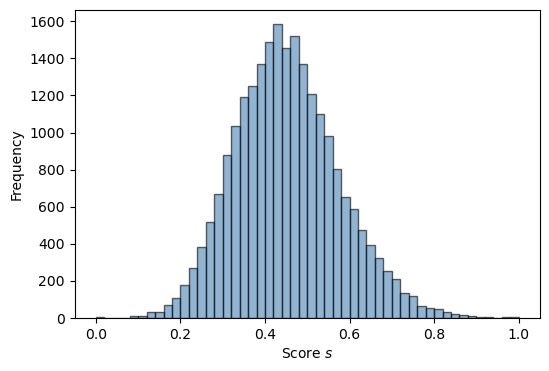

In [31]:
#| code-fold: true
#| fig-cap: Histogram of scores. Code sourced from Phil Chodrow Lecture Notes.
#| label: fig-score-histogram

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
hist = ax.hist(s, bins = 50, color = "steelblue", alpha = 0.6, linewidth = 1, edgecolor = "black")
labs = ax.set(xlabel = r"Score $s$", ylabel = "Frequency") 

Now to choose our threshold. To find the optimal risk cutoff, we can employ the very elegant and efficient brute force approach. We can test $100$ values of our threshold $t$ between $0$ and $1$, calculating whether each borrower falls above or below the threshold. Borrowers who fall above the threshold are considered to be too high of a risk to give a loan to, while borrowers below the threshold will be approved to receive a loan. We can then compare these labels to the real labels from the "loan_status" column. Based on this, we can calculate the total profit of the bank. If the model predicts that a borrower will pay back their loan and the borrower actually does, the bank will make a profit of $$loan\_amnt*(1+0.25*int\_rate)^{10} - loan\_amnt$$ which assumes that the bank profits $25\%$ of the interest rate after paying operating expenses and that the loan is paid back in ten years. If the model predicts that the borrower will pay back their loans and they actually default, the bank's profit can be calculated by $$loan\_amnt*(1 + 0.25*int\_rate)^3 - 1.7*loan\_amnt$$ which assumes that the borrower defaults after three years causing the bank to lose $70\%$ of the principal. This amount is typically a negative value. In the banking industry this is considered to be "bad for business". We can sum the values of these two profits to determine the total profit of the bank. We can calculate the profit yielded by each threshold and then set our best threshold to be whichever yields the highest profit. In our figure below, it appears optimal to reject any borrowers with a risk of default higher than $58\%$, which yields a profit of $\$1452.12$ per prospective borrower. Not too bad!

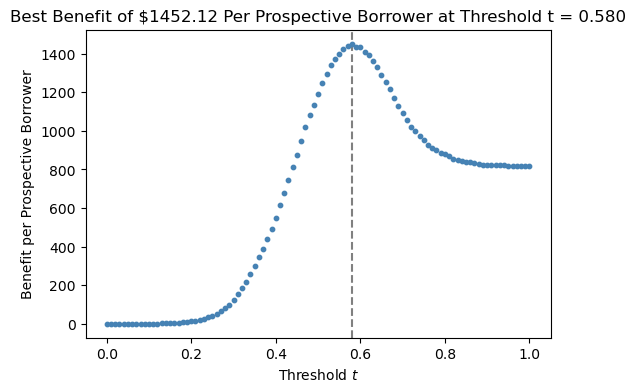

In [32]:
# Figure code sourced from Phil Chodrow Lecture Notes and modified for the algorithm used in this post.

best_benefit = 0
best_threshold = 0

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(0, 1, 101): 
    y_pred = s >= t
    tn = np.sum((X_train['loan_amnt']*(1 + 0.25*X_train['loan_int_rate'])**10 - X_train['loan_amnt'])[(y_train == 0)&(y_pred == 0)])
    fn = np.sum((X_train['loan_amnt']*(1 + 0.25*X_train['loan_int_rate'])**3 - 1.7*X_train['loan_amnt'])[(y_train == 1)&(y_pred == 0)])
    benefit = (tn + fn)/len(X_train)
    ax.scatter(t, benefit, color = "steelblue", s = 10)
    if benefit > best_benefit: 
        best_benefit = benefit
        best_threshold = t

ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Benefit per Prospective Borrower", title = f"Best Benefit of ${best_benefit:.2f} Per Prospective Borrower at Threshold t = {best_threshold:.3f}")

# Evaluating The Model as a Banker

So how does our model perform on a testing dataset where the model weights have not been influenced by the data it is transforming? Let's find out!

In [33]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test["loan_int_rate"] = df_test["loan_int_rate"]/100
X_test, y_test = preprocess_data(df_test)

Using the same features we used before and the weights from our trained Logistic Regression model, we can transform the testing data into a set of probabilities as well.

In [34]:
s = calculate_norm_scores(X_test[cols], weights)

Using the best threshold we found to be optimal from the training data, we can assign labels to each of our testing borrowers and calculate the bank's total profit based on these predictions. We find that the bank profits $\$1366.84$ per prospective borrower, which is very similar to the profits we found with the training data. Success!

In [35]:
y_pred = s >= best_threshold
tn = np.sum((X_test['loan_amnt']*(1 + 0.25*X_test['loan_int_rate'])**10 - X_test['loan_amnt'])[(y_test == 0)&(y_pred == 0)])
fn = np.sum((X_test['loan_amnt']*(1 + 0.25*X_test['loan_int_rate'])**3 - 1.7*X_test['loan_amnt'])[(y_test == 1)&(y_pred == 0)])
benefit = (tn + fn)/len(X_test)
benefit

1366.8358295680039

# Evaluating the Model as a Borrower

While optimizing profits can certaintly be exhilerating, it does not come without its costs. Because the model cannot predict with complete certainty whether a borrower will default, there are bound to be borrowers who are denied loans even if they actually would have been able to pay back their loans. In the name of fairness, we can examine who was approved and denied loans and determine if certain groups of people are advantaged or disadvantaged by our model.

We first look at the average prediction based on the borrowers age. Our model predicts that borrowers from ages $20$ to $30$ will have the highest rate of default at $14.4\%$. While this does disadvantage young people, the model still predicts the rate of default to be much lower than the actual rate, meaning many young people that are approved a loan will still default. The greatest disparity in predictions is in the $50$ to $60$ year old age group, where only $2.9\%$ are predicted to default when this group actually has the highest rate at $28.9\%$. 

In [36]:
df_test["y_pred"] = y_pred
df_test.groupby(pd.cut(df_test["person_age"], [20,30,40,50,60,80]))[["y_pred", "loan_status"]].mean().reset_index()

,person_age,y_pred,loan_status
0,"(20, 30]",0.143839,0.223499
1,"(30, 40]",0.088584,0.208466
2,"(40, 50]",0.054545,0.202429
3,"(50, 60]",0.029412,0.289474
4,"(60, 80]",0.083333,0.461538


Next we can look at the predictions for default based on loan intent. Just as with the age groups, the predicted rates of default are much lower than the actual rates of default, although by varying amounts. Among the highest predicted rates of default are medical expenses with a predicted rate of $19.6\%$ compared to the actual default rate of $28.2\%$. This means it is significantly harder to get approved for a medical loan than other loans like education or venture loans, which are given predicted default rates of $6.3\%$ and $8.4\%$ respectively.

In [37]:
df_test.groupby("loan_intent")[["y_pred", "loan_status"]].mean().reset_index()

,loan_intent,y_pred,loan_status
0,DEBTCONSOLIDATION,0.201327,0.279497
1,EDUCATION,0.062925,0.167421
2,HOMEIMPROVEMENT,0.118506,0.246088
3,MEDICAL,0.195713,0.281553
4,PERSONAL,0.119238,0.219227
5,VENTURE,0.084025,0.145701


Lastly, we can look at income brackets. Borrowers that make less than $\$40000$ are the most likely to default, which the model reflects by making it the most difficult for these borrowers to access credit. As the income brackets increase, the model predicts lower and lower rates of default even though the actual rates of default seem to level off above $\$70000$. 

In [38]:
df_test["y_pred"] = y_pred
df_test.groupby(pd.cut(df_test["person_income"], [0,40000,70000,100000, 150000,1000000]))[["y_pred", "loan_status"]].mean().reset_index()

,person_income,y_pred,loan_status
0,"(0, 40000]",0.236352,0.370569
1,"(40000, 70000]",0.121875,0.198972
2,"(70000, 100000]",0.068262,0.119625
3,"(100000, 150000]",0.012797,0.105008
4,"(150000, 1000000]",0.00495,0.115044


# Conclusion

Throughout this post, we examine automated decision algorithms, which take advantage of threshold setting to determine if borrowers should be approved loans or not. By assigning variable costs to different kinds of errors, we define our optimal model as one that does not necessarily minimize all error, but minimizes a specific kind of error. Using this approach, we find parameters that can be used to maximize the profit for our bank. One of the ethical concerns with implementing an algorithm like this is that certain demographs are likely to be assigned higher or lower risk scores simply based on the demographic they are part of. As such, certain groups can be unfairly advantaged or disadvantaged in decision-making processes like approving loans. In the case of the bank, one such concern is that people seeking medical loans have higher rates of default and thus are denied credit by the model at higher rates. This brings up the question: is this fair? From a profit standpoint, this certaintly is fair as the bank wants to minimize the risk they take on when giving credit and riskier investments should be taken on less frequently. However, from a humanitarian standpoint, this is an unfair policy as medical expenses are often for life-or-death procedures and it could be considered inhumane to deny the borrower the money they need for such a procedure even if they are perhaps unable to pay it back. Thus it comes down to how you define fairness: Is fairness based on equal exchanges and kept promises or is it our responsibility as humans to provide for one another even when there is no direct benefit to us? It seems that there are some decisions that even the best machines cannot make.